In [1]:
import healpy as hp
import numpy as np
from numpy import sin, cos
import pylab as plt
from coord_utils import compute_w, polar_to_cartesian, phase_vector, generate_phase_vector, skycoord_to_ephem
from ant_array2 import RadioArray
from allsky_viewer import AllSkyViewer, generate_skycat
from astropy.time import Time
import ephem
import numpy as np
import pylab as plt
import h5py
import hickle as hkl
from astropy.coordinates import SkyCoord
import pygdsm
import h5py
from astropy.coordinates import SkyCoord

In [2]:
NSIDE = 8
pix = np.arange(hp.nside2npix(NSIDE))
lon, lat = hp.pix2ang(NSIDE, pix, lonlat=True)

h = h5py.File('eda_antenna_locations_v2.h5')
xyzc = h['xyz_celestial']

In [3]:
filename_data = 'test-data/eda2/20200209/chan_204_20200209T034646_vis_real.fits'
filename_ant  = 'eda_antenna_locations_v2.h5'
# Setup array
f_mhz = np.array([159.3750])
lat = '-26:42:11:95'
lon = '116:40:14.93'
elev = 500
t = Time('2020-02-09T03:46:46.0', format='isot')
sun = ephem.Sun()

# Initialize EDA array
eda = RadioArray(lat, lon, elev, f_mhz, filename_ant, t0=t.datetime, verbose=True, phase_center=sun)
eda.load_fits_data(filename_data)

Time: 2020/2/9 03:46:46
Sun 	RA / DEC:  (21:29:01.23, -14:51:39.7) 
	ALT / AZ:  (74:49:40.3, 40:43:47.7)
ZENITH: (20:47:08.87, -26:46:33.5)
HA, D: (-0.18270382264997043, -14:51:39.7)


/Users/dancpr/Data/eda_post_x/ant_array2.py:161: RuntimeWarning: invalid value encountered in sqrt
  ng     = np.sqrt(1 - lg**2 - mg**2)


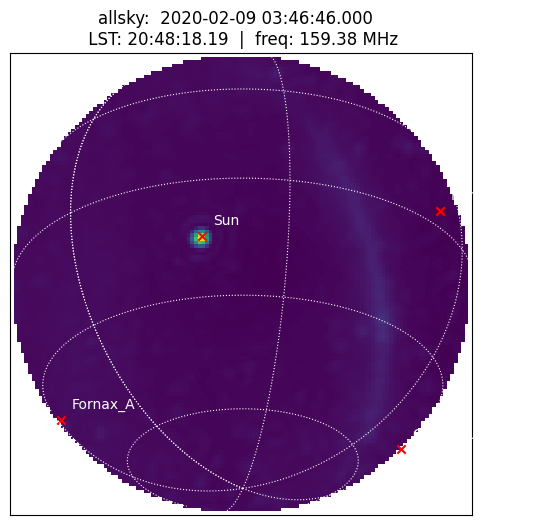

In [4]:
eda.gsm.generate(100)
img = eda.make_image()

asv = AllSkyViewer(observer=eda, ts=t, f_mhz=f_mhz[0], n_pix=128)
skycat = generate_skycat(asv.observer)
asv.load_skycat(skycat)

asv.new_fig(6)
asv.plot(img, overlay_srcs=True)

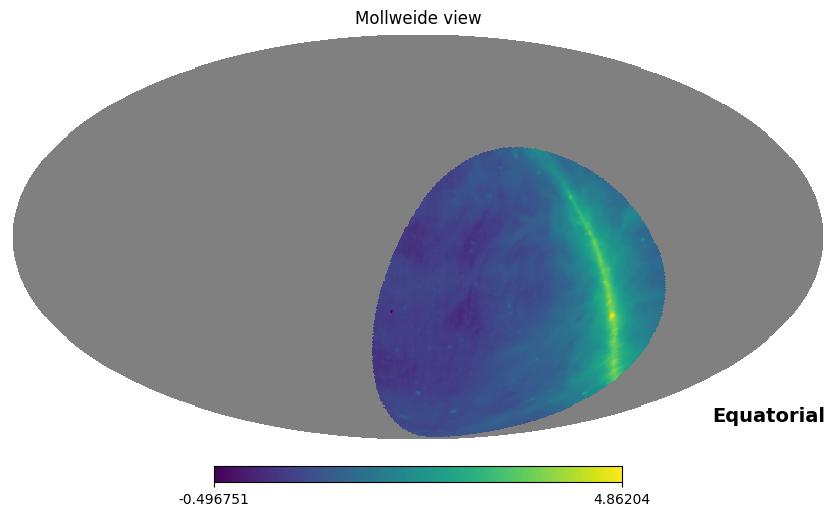

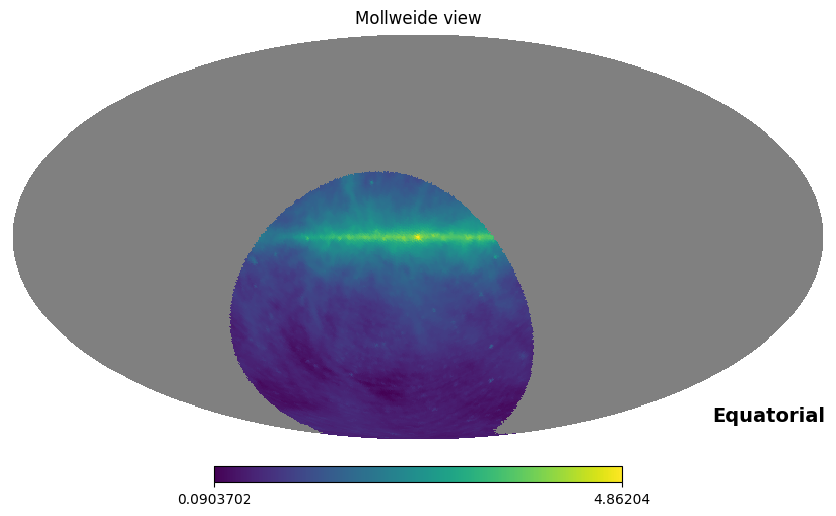

In [170]:
NSIDE = 128
d_8 = hp.ud_grade(hmap, NSIDE)
pix = np.arange(len(d_8))

# galactic longitude and latitude
_lon, _lat = hp.pix2ang(NSIDE, pix, lonlat=True)
lon, lat   = hp.pix2ang(NSIDE, pix[~d_8.mask], lonlat=True)

assert np.allclose(sc[~mask].l.value, lon)
assert np.allclose(sc[~mask].b.value, lat)

# Two conversion from lon, lat to ra, dec
# 1. healpy rotation
# This is faster than astropy 
rot_gal2eq = hp.Rotator(coord="GC")
ra_deg, dec_deg = rot_gal2eq(lon, lat, lonlat=True)
_ra_deg, _dec_deg = rot_gal2eq(_lon, _lat, lonlat=True)

assert np.allclose(sc[~mask].icrs.ra.to('deg').wrap_at(Angle(np.pi, unit='rad')).value, ra_deg, atol=1e-4)
assert np.allclose(sc[~mask].icrs.dec.to('deg').value, dec_deg, atol=1e-4)

# Pixels corresponding to ra, dec locations
pix_c = hp.ang2pix(NSIDE, ra_deg, dec_deg, lonlat=True) 
_pix_c = hp.ang2pix(NSIDE, _ra_deg, _dec_deg, lonlat=True)

# 2. astropy skycoord
#sc = SkyCoord(lon, lat, frame='galactic', unit=('deg', 'deg'))

# Plot to compare
hp.mollview(d_8, coord='GC')
#hp.projscatter(sc.icrs.ra.value, sc.icrs.dec.value, lonlat=True, marker='o')
#hp.projscatter(ra_deg, dec_deg, lonlat=True, marker='x', alpha=0.7, color='red')
plt.show()
hp.mollview(d_8[_pix_c], coord='GC')

/var/folders/n3/pbwrsp713bd28_l4xt61c7zh0000gn/T/ipykernel_79244/2345635307.py:18: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(hpdata), coord='c')


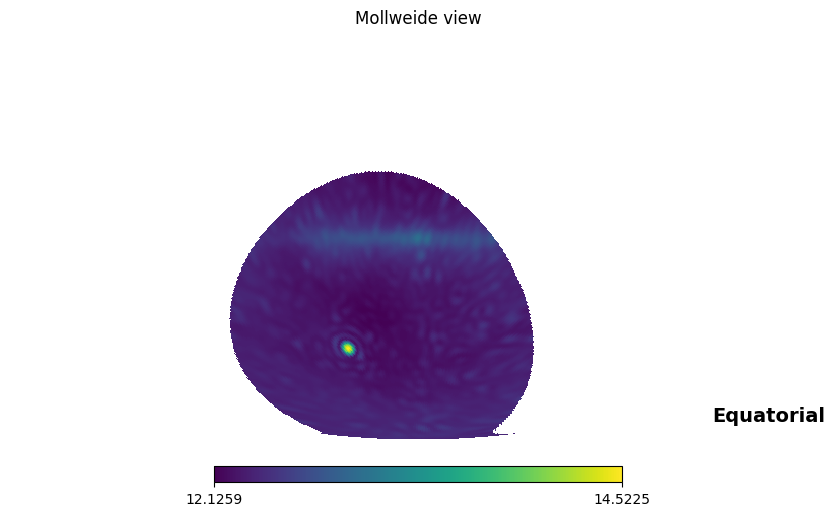

In [171]:
ra0, dec0 = eda.radec_of(0, np.pi/2)
ra, dec = np.deg2rad(ra_deg), np.deg2rad(dec_deg)

H = ra0 - ra 
d = dec

c = generate_phase_vector(xyzc, H, d, eda.workspace['f'], conj=False)
c = c.T
c *= eda.workspace['c0'] # Correct for Sun phase center

B = np.abs(np.einsum('ip,pq,iq->i', c, eda.data, np.conj(c), optimize=True))

hpdata = np.zeros_like(pix)

hpdata[pix[~d_8.mask]] = B
#hpdata = hpdata[_pix_c]

hp.mollview(np.log(hpdata), coord='c')

/var/folders/n3/pbwrsp713bd28_l4xt61c7zh0000gn/T/ipykernel_79244/2110774419.py:19: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(hpdata), coord='g')


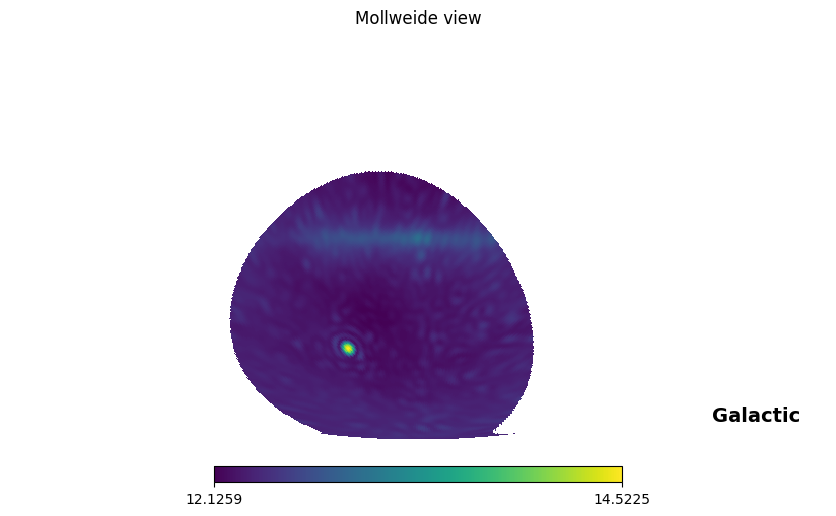

In [179]:
ra0, dec0 = eda.radec_of(0, np.pi/2)

ra = sc[~mask].icrs.ra.to('rad').value
dec = sc[~mask].icrs.dec.to('rad').value

H = ra0 - ra 
d = dec

c = generate_phase_vector(xyzc, H, d, eda.workspace['f'], conj=False)
c = c.T
c *= eda.workspace['c0'] # Correct for Sun phase center

B = np.abs(np.einsum('ip,pq,iq->i', c, eda.data, np.conj(c), optimize=True))

hpdata = np.zeros_like(pix)

hpdata[pix0[~mask]] = B

hp.mollview(np.log(hpdata), coord='g')

In [102]:
len(sc[~mask])

49152

In [135]:


ra0, dec0 = eda.radec_of(0, np.pi/2)
ra, dec = np.deg2rad(ra_deg), np.deg2rad(dec_deg)

H = ra0 - ra 
d = dec



ra1 = sc[~mask].icrs.ra.to('rad').value
dec1 = sc[~mask].icrs.dec.to('rad').value

assert np.allclose(ra, ra1)

H1 = sc_zen.icrs.ra.to('rad').value - ra 
d1 = dec



assert np.allclose(H, H1)
assert np.allclose(d, d1)

AssertionError: 

In [119]:
ra = sc[~mask].icrs.ra.to('rad').value
dec = sc[~mask].icrs.ra.to('rad').value

H1 = sc_zen.icrs.ra.to('rad').value - ra 
d1 = dec

assert np.allclose(H, H1)
assert np.allclose(d, d1)

#c = generate_phase_vector(xyzc, H, d, eda.workspace['f'], conj=False)
#c = c.T
#c *= eda.workspace['c0'] # Correct for Sun phase center

#B = np.abs(np.einsum('ip,pq,iq->i', c, eda.data, np.conj(c), optimize=True))

#hpdata = np.zeros_like(pix0)

#hpdata[pix0[~mask]] = B

#hp.mollview(np.log(hpdata), coord='c')

AssertionError: 

In [6]:
def pix2sky(nside: int, pix_ids: np.ndarray) -> SkyCoord:
    """ Convert a healpix pixel_id into a SkyCoord """
    gl, gb = hp.pix2ang(nside, pix_ids, lonlat=True)
    sc = SkyCoord(gl, gb, frame='galactic', unit=('deg', 'deg'))
    return sc

def sky2pix(nside: int, sc: SkyCoord) -> np.ndarray:
    """ Convert a SkyCoordinate into a healpix pixel_id """
    gl, gb = sc.galactic.l.to('deg').value, sc.galactic.b.to('deg').value
    pix = hp.ang2pix(nside, gl, gb, lonlat=True)
    return pix

def test_pix2sky():
    NSIDE = 32
    pix = np.arange(hp.nside2npix(NSIDE))
    sc  = pix2sky(NSIDE, pix)
    pix_roundtrip = sky2pix(NSIDE, sc)
    assert np.allclose(pix, pix_roundtrip)

test_pix2sky()

<SkyCoord (Galactic): (l, b) in deg
    [( 45.,  89.6345165), (135.,  89.6345165), (225.,  89.6345165), ...,
     (135., -89.6345165), (225., -89.6345165), (315., -89.6345165)]>

In [123]:
gsm = pygdsm.GlobalSkyModel()
hmap = np.log(gsm.generate(1000))

hmap = hp.ud_grade(hmap, 128)

NPIX = hp.get_map_size(hmap)
NSIDE = hp.npix2nside(NPIX)
pix0 = np.arange(NPIX)

sc  = pix2sky(NSIDE, pix0)


In [55]:
sc_zen = eda.get_zenith()

pix_zen = sky2pix(NSIDE, sc_zen)
vec_zen = hp.pix2vec(NSIDE, pix_zen)

pix_visible = hp.query_disc(NSIDE, vec=vec_zen, radius=np.pi/3)

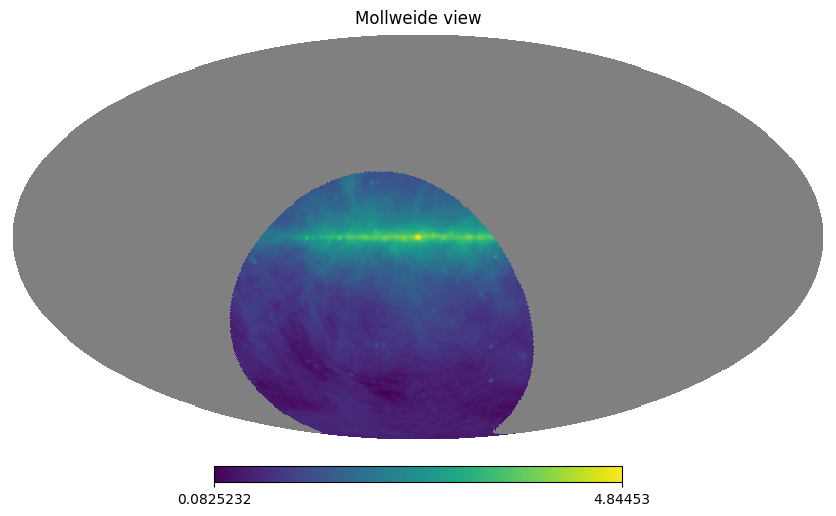

In [126]:
hmap = hp.ma(hmap)
mask = np.ones_like(hmap, dtype='bool')
mask[pix_visible] = False
hmap.mask = mask

hp.mollview(hmap)

In [57]:
mask.shape
sc.icrs.ra.to('rad').value.shape

(196608,)

In [60]:
ra = sc.icrs.ra.to('rad').value[~mask]
dec = sc.icrs.ra.to('rad').value[~mask]

In [91]:
sc.icrs.ra.to('degree').value[pix_visible] - ra_deg

array([ 3.59999993e+02,  3.59999993e+02,  3.59999993e+02, ...,
       -3.35755873e-06, -3.29743186e-06, -3.26570802e-06])

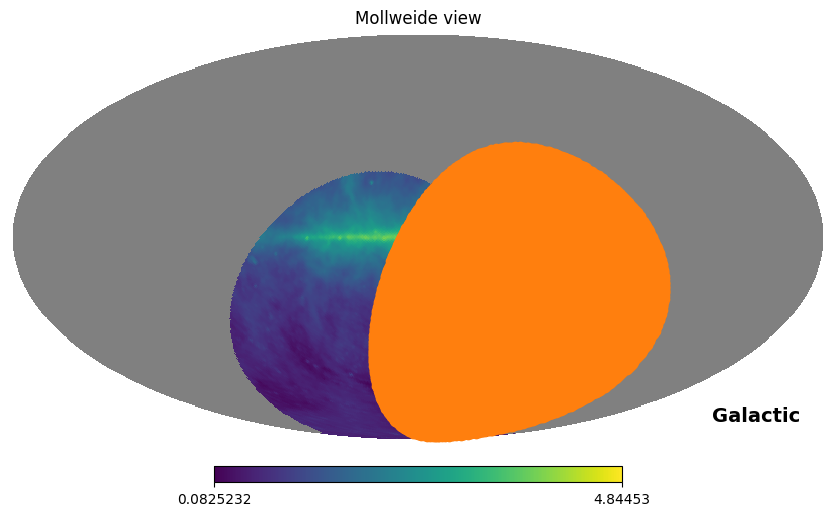

In [89]:
hp.mollview(hmap, coord='G')
hp.projscatter(sc.icrs.ra.to('degree').value[pix_visible], sc.icrs.dec.to('degree').value[pix_visible], lonlat=True, alpha=0.01)
hp.projscatter(ra_deg, dec_deg,  lonlat=True)

/var/folders/n3/pbwrsp713bd28_l4xt61c7zh0000gn/T/ipykernel_79244/3882049996.py:14: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(hpdata), coord='c')


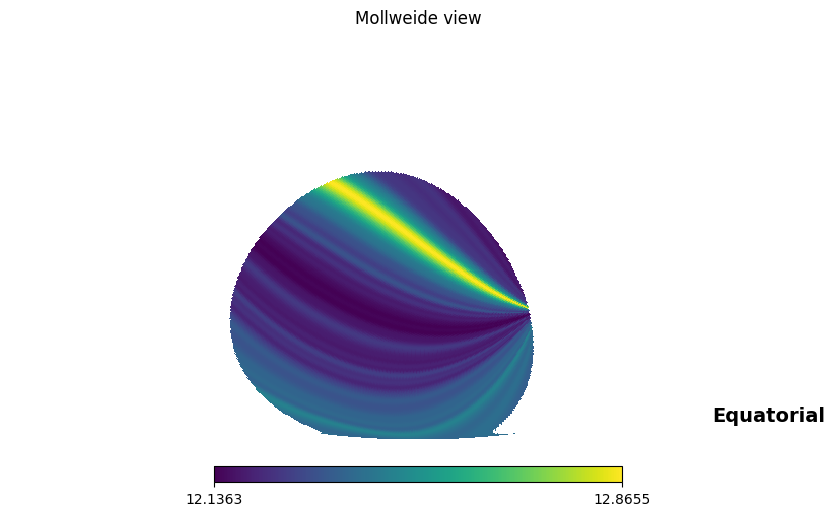

In [118]:
H = sc_zen.icrs.ra.to('rad').value - ra 
d = sc_zen.icrs.dec.to('rad').value

c = generate_phase_vector(xyzc, H, d, eda.workspace['f'], conj=False)
c = c.T
c *= eda.workspace['c0'] # Correct for Sun phase center

B = np.abs(np.einsum('ip,pq,iq->i', c, eda.data, np.conj(c), optimize=True))

hpdata = np.zeros_like(pix0)

hpdata[pix0[~mask]] = B

hp.mollview(np.log(hpdata), coord='c')